In [1]:
from Functions import LoadData
from Functions import TestStrategy
from Functions import Backtesting
import os

In [2]:
current_directory = os.getcwd()
path = os.path.join(current_directory, 'Stocks_financials')

loader = LoadData(path)
prices, financials = loader.Load(start_date='2014-09-01', end_date=None)

Data processed for the following tickers: MSFT, V, NFLX, SO, DUK, PLD, VZ, T, CVX, VMC, NVDA, GE, KO, JNJ, GS, HD, AMD, ADM, META, GOOGL, TSLA, JPM, XOM, AAPL


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [3]:
prices

{'MSFT': Date
 2014-09-02     45.090000
 2014-09-03     44.959999
 2014-09-04     45.259998
 2014-09-05     45.910000
 2014-09-08     46.470001
                  ...    
 2024-09-16    431.339996
 2024-09-17    435.149994
 2024-09-18    430.809998
 2024-09-19    438.690002
 2024-09-20    435.269989
 Name: Close, Length: 2531, dtype: float64,
 'V': Date
 2014-09-02     53.682499
 2014-09-03     53.724998
 2014-09-04     53.564999
 2014-09-05     53.552502
 2014-09-08     53.942501
                  ...    
 2024-09-16    290.480011
 2024-09-17    291.559998
 2024-09-18    288.480011
 2024-09-19    285.239990
 2024-09-20    284.769989
 Name: Close, Length: 2531, dtype: float64,
 'NFLX': Date
 2014-09-02     68.085716
 2014-09-03     68.198570
 2014-09-04     67.524284
 2014-09-05     67.954285
 2014-09-08     68.475716
                  ...    
 2024-09-16    696.500000
 2024-09-17    706.909973
 2024-09-18    690.469971
 2024-09-19    704.320007
 2024-09-20    701.030029
 Name: Close, L

In [4]:
financials

{'MSFT':                                       Financial Ratio    2024-06    2024-03  \
 0                                        Gross Margin  69.764444  69.894414   
 1                                       SG&A to Sales  25.120144   25.19063   
 2                                    Operating Margin    44.6443  44.703784   
 3                                       Pretax Margin  43.972797  44.493288   
 4                                          Net Margin  35.955973  36.427231   
 ..                                                ...        ...        ...   
 95                          Net Debt/Total Equity (%)   8.309464  10.352673   
 96                              Total Debt/Equity (%)   36.44707  41.962536   
 97                             Net Debt/Total Capital   6.089881   7.292539   
 98                           Total Debt/Total Capital  26.711508   29.55888   
 99  All figures in billions of U.S. Dollar except ...        NaN        NaN   
 
       2023-12    2023-09    2

In [5]:
list(financials["AAPL"]["Financial Ratio"])

['Gross Margin',
 'SG&A to Sales',
 'Operating Margin',
 'Pretax Margin',
 'Net Margin',
 'Free Cash Flow Margin',
 'Capex To Sales',
 'Return on Assets',
 'Return on Equity ',
 'Return on Common Equity',
 'Return on Total Capital',
 'Return on Invested Capital',
 'Cash Flow Return on Invested Capital',
 ' Valuation',
 'Price/Sales',
 'Price/Earnings',
 'Price/Book Value',
 'Price/Tangible Book Value',
 'Price/Cash Flow',
 'Price/Free Cash Flow',
 'Dividend Yield (%)',
 'Enterprise Value/EBIT',
 'Enterprise Value/EBITDA',
 'Enterprise Value/Sales',
 ' Per Share',
 'Sales per Share',
 'EBIT (Operating Income) per Share',
 'EPS (recurring)',
 'EPS (basic)',
 'EPS (diluted)',
 'Dividends per Share',
 'Dividend Payout Ratio (%)',
 'Book Value per Share',
 'Tangible Book Value per Share',
 'Cash Flow per Share',
 'Free Cash Flow per Share',
 'Diluted Shares Outstanding  (M) (M)',
 'Basic Shares Outstanding  (M) (M)',
 'Total Shares Outstanding  (M) (M)',
 ' Asset Turnover Analysis',
 'Cash 

In [6]:
list(financials["V"]["Financial Ratio"])

['SG&A to Sales',
 'Operating Margin',
 'Pretax Margin',
 'Net Margin',
 'Free Cash Flow Margin',
 'Capex To Sales',
 'Return on Assets',
 'Return on Equity ',
 'Return on Common Equity',
 'Return on Total Capital',
 'Return on Invested Capital',
 'Cash Flow Return on Invested Capital',
 ' Valuation',
 'Price/Sales',
 'Price/Earnings',
 'Price/Book Value',
 'Price/Tangible Book Value',
 'Price/Cash Flow',
 'Price/Free Cash Flow',
 'Dividend Yield (%)',
 'Enterprise Value/EBIT',
 'Enterprise Value/EBITDA',
 'Enterprise Value/Sales',
 ' Per Share',
 'Sales per Share',
 'EBIT (Operating Income) per Share',
 'EPS (recurring)',
 'EPS (basic)',
 'EPS (diluted)',
 'Dividends per Share',
 'Dividend Payout Ratio (%)',
 'Book Value per Share',
 'Tangible Book Value per Share',
 'Cash Flow per Share',
 'Free Cash Flow per Share',
 'Diluted Shares Outstanding  (M)',
 'Basic Shares Outstanding  (M)',
 'Total Shares Outstanding  (M)',
 ' Asset Turnover Analysis',
 'Cash & ST Investments',
 'Receivab

In [7]:
stocks = ['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM', 'META', 'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']
column_name = "Financial Ratio" 
reference_column = list(financials[stocks[0]][column_name])

all_equal = True

for stock in stocks[1:]:
    current_column = list(financials[stock][column_name])
    
    if current_column != reference_column:
        all_equal = False
        print(f"Las columnas no son iguales para {stock}.")
        break

if all_equal:
    print("La columna es igual para todos los tickers.")
else:
    print("Las columnas no son iguales entre todos los tickers.")
    

Las columnas no son iguales para V.
Las columnas no son iguales entre todos los tickers.


In [8]:
# DUK, JPM, GS
#['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM', 'META', 'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']
stocks = ["MSFT", "AAPL", "GOOGL", 'V', 'NFLX', 'SO', 'DUK', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'HD', 'AMD', 'ADM', 'META', 'TSLA', 'XOM'] 
column_name = "Financial Ratio"      
common_items = set(financials[stocks[0]][column_name])
for stock in stocks[1:]:
    current_items = set(financials[stock][column_name])
    common_items = common_items.intersection(current_items)
if common_items:
    print(f"Los siguientes ítems son comunes en todos los tickers: {common_items}")
else:
    print("No hay ítems comunes en todos los tickers.")

Los siguientes ítems son comunes en todos los tickers: {' Asset Turnover Analysis', 'Capex To Sales', 'EPS (diluted)', 'EPS (recurring)', 'Note: EBIT Return on Assets (%)', 'Fixed Assets', ' = Reinvestment Rate (%)', '   Days of Inventory on Hand', 'EBIT (Operating Income) per Share', ' Coverage', ' Operating Efficiency', 'Return on Invested Capital', 'CFO/Total Debt', ' Valuation', 'Cash & ST Inv/Current Assets', 'Operating Margin', '   Asset Turnover (x)', '    + Days of Sales Outstanding', 'Price/Free Cash Flow', ' = Return on Assets (%)', 'Free Cash Flow Margin', 'Total Debt/Total Assets (%)', 'Quick Ratio (x)', 'LT Debt/Total Equity', 'Net Debt/(EBITDA-Capex)', 'LT Debt/FFO', 'Book Value per Share', 'Cash Flow per Share', ' DuPont Analysis', 'Pretax Margin', 'Return on Equity ', 'Net Debt/Total Equity (%)', 'Net Margin', '    - Days of Payables Outstanding', 'Cash Flow Return on Invested Capital', 'Receivables Turnover', ' Per Share', 'LT Debt/Total Capital', 'Cash & ST Investment

In [9]:
common_items, len(common_items)

({'    + Days of Sales Outstanding',
  '    - Days of Payables Outstanding',
  '    x Earnings Retention (1-Payout) (%)',
  '    x Equity Multiplier (Assets/Equity)',
  '    x Pretax Margin (%)',
  '    x Tax Rate Complement (1-Tax Rate) (%)',
  '   Asset Turnover (x)',
  '   Days of Inventory on Hand',
  ' = Operating Cycle',
  ' = Pretax Return on Assets (%)',
  ' = Reinvestment Rate (%)',
  ' = Return on Assets (%)',
  ' = Return on Equity (%)',
  ' Asset Turnover Analysis',
  ' Coverage',
  ' DuPont Analysis',
  ' Leverage',
  ' Liquidity',
  ' Operating Cycle - Days',
  ' Operating Efficiency',
  ' Per Share',
  ' Valuation',
  'Asset Turnover ',
  'Book Value per Share',
  'CFO/Current Liabilities',
  'CFO/Interest Expense',
  'CFO/Total Debt',
  'Capex To Sales',
  'Cash & ST Inv/Current Assets',
  'Cash & ST Investments',
  'Cash Flow Return on Invested Capital',
  'Cash Flow per Share',
  'Cash Ratio',
  'Current Assets',
  'Current Ratio (x)',
  'EBIT (Operating Income) per S

In [10]:
offensive_tickers = ["MSFT", "AAPL", "GOOGL", 'V', 'NFLX', 'SO', 'DUK', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'HD', 'AMD', 'ADM', 'META', 'TSLA', 'XOM']   
defensive_tickers = ['JNJ', 'PG']      
protective_tickers = ['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE',
  'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM', 'META', 'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']    

In [11]:
strategy = TestStrategy(prices, financials, offensive_tickers, defensive_tickers, protective_tickers)
chosen_universe = strategy.run_strategy(start_date='2014-09-01')


In [12]:
chosen_universe

,Date,Chosen Universe,Selected Stocks
0,2015-09-01,Defensive,"[JNJ, PG]"
1,2016-03-01,Offensive,"[VZ, HD, V, META, AAPL, JNJ, GE, KO]"
2,2016-09-01,Offensive,"[VZ, HD, META, V, AAPL, MSFT, JNJ, KO]"
3,2017-03-01,Offensive,"[HD, META, VZ, V, MSFT, NVDA, JNJ, GOOGL]"
4,2017-09-01,Offensive,"[HD, META, VZ, V, NVDA, MSFT, SO, JNJ]"
5,2018-03-01,Offensive,"[HD, META, V, NVDA, JNJ, MSFT, VZ, GOOGL]"
6,2018-09-01,Offensive,"[HD, META, NVDA, V, JNJ, MSFT, VZ, GOOGL]"
7,2019-03-01,Offensive,"[NVDA, V, KO, MSFT, AAPL, VZ, META, NFLX]"
8,2019-09-01,Offensive,"[V, AAPL, MSFT, KO, NVDA, META, VZ, GE]"
9,2020-03-01,Offensive,"[KO, AAPL, V, MSFT, NVDA, VZ, META, NFLX]"


In [13]:
chosen_universe["Chosen Universe"].value_counts()

Chosen Universe
Offensive    17
Defensive     2
Name: count, dtype: int64

In [14]:
strategy.get_momentum_dataframe()

,MSFT,V,NFLX,SO,DUK,PLD,VZ,T,CVX,VMC,...,HD,AMD,ADM,META,GOOGL,TSLA,JPM,XOM,AAPL,Average
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01,0.016243,0.006919,0.037001,0.004827,-0.003849,-0.007029,0.003055,0.006178,-0.018273,0.016453,...,0.007467,-0.020007,-0.022755,0.027148,0.023131,0.001567,-0.005847,-0.007308,-0.022146,0.003004
2016-09-01,0.026191,0.011654,-0.007971,0.014827,0.010961,0.030120,0.012238,0.018232,0.020168,0.018714,...,0.012941,0.137851,0.001166,0.030242,0.018951,-0.006827,0.005739,0.013320,-0.001873,0.020932
2017-03-01,0.020645,0.017191,0.040985,0.005579,0.010180,0.025544,-0.000203,0.011863,0.026441,0.018376,...,0.014021,0.183070,0.025821,0.021560,0.015136,0.026749,0.041710,0.002146,0.032162,0.029506
2017-09-01,0.022398,0.021384,0.054587,-0.004468,0.008251,0.015520,-0.005922,-0.006123,0.006323,0.005989,...,0.009986,0.059727,-0.003941,0.027861,0.016708,0.047633,0.026924,-0.010444,0.038169,0.018621
2018-03-01,0.033159,0.028701,0.068371,-0.013051,-0.006905,0.015051,-0.001757,-0.009934,0.000791,-0.000939,...,0.020581,-0.006814,-0.009482,0.024025,0.023892,0.029918,0.021457,-0.004706,0.023446,0.011375
2018-09-01,0.035498,0.030088,0.070611,-0.006811,-0.005203,0.005294,0.011742,-0.011416,0.009554,-0.004883,...,0.025810,0.071478,0.017439,0.003975,0.022884,-0.007434,0.020427,0.005397,0.030303,0.013716
2019-03-01,0.016197,0.016956,0.024393,0.013481,0.015028,0.014240,0.015608,-0.011562,0.007141,-0.001876,...,0.002892,0.083463,0.003667,-0.002940,0.003272,0.003269,-0.006993,0.005457,0.002369,0.006364
2019-09-01,0.018857,0.018773,-0.012409,0.024865,0.011759,0.020988,0.006686,0.009623,0.001145,0.021999,...,0.012947,0.036845,-0.020836,0.009811,-0.001010,-0.014160,-0.001119,-0.010177,-0.002620,0.003671
2020-03-01,0.032302,0.018258,0.005347,0.017983,0.002929,0.016634,-0.003201,0.011332,-0.018670,0.008477,...,0.014872,0.059391,-0.006951,0.016872,0.015940,0.083163,0.011782,-0.032461,0.042216,0.015831


In [15]:
financials['AAPL']

,Financial Ratio,2024-06,2024-03,2023-12,2023-09,2023-06,2023-03,2022-12,2022-09,2022-06,...,2016-12,2016-09,2016-06,2016-03,2015-12,2015-09,2015-06,2015-03,2014-12,2014-09
0,Gross Margin,45.962039,45.585827,45.026782,44.13113,43.449248,43.181033,43.059372,43.309631,43.314273,...,38.040105,38.222251,38.437337,38.315222,38.464554,38.492237,38.584754,38.955907,38.949784,38.577525
1,SG&A to Sales,14.687904,14.602369,14.262936,14.309717,14.218627,14.018359,13.651858,13.020886,12.781066,...,11.405134,11.314686,11.042417,10.541644,9.974238,9.683375,9.577107,9.545534,9.591416,9.841523
2,Operating Margin,31.274134,30.983457,30.763846,29.821412,29.230621,29.162674,29.407515,30.288744,30.533207,...,26.63497,26.907565,27.39492,27.773579,28.490316,28.808862,29.007647,29.410373,29.358368,28.736002
3,Pretax Margin,31.346488,30.949917,30.706289,29.674002,29.014177,29.013101,29.283655,30.204043,30.369354,...,28.038771,28.64825,29.422325,30.345741,31.306865,31.353364,30.968899,30.731225,30.152894,29.186767
4,Net Margin,26.440666,26.305804,26.163192,25.306234,24.68139,24.492917,24.557913,25.309641,25.708955,...,20.791242,21.326543,21.889283,22.532769,23.147143,23.086003,22.796794,22.62533,22.273766,21.561415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Net Debt/Total Equity (%),59.217785,50.462302,47.152497,100.368487,77.642101,86.46192,105.337846,166.119356,122.98002,...,20.467558,15.498756,18.317383,18.848356,19.404056,19.153785,15.687039,8.352325,3.194733,9.160264
96,Total Debt/Equity (%),151.861846,140.968272,145.802969,199.417501,181.305372,176.348982,195.867929,261.446164,205.983789,...,66.129617,67.861738,67.120538,61.224771,49.08745,54.00863,43.299888,34.006945,29.517222,31.641371
97,Net Debt/Total Capital,23.512011,20.941471,19.183046,33.521249,27.600646,31.287222,35.602996,45.95964,40.191678,...,12.320234,9.233049,10.960582,11.690732,13.015217,12.436826,10.947,6.232755,2.466647,6.9585
98,Total Debt/Total Capital,60.295693,58.500761,59.317009,66.601819,64.451443,63.813871,66.201136,72.333362,67.31853,...,39.806037,40.427163,40.16295,37.974792,32.925273,35.068574,30.216275,25.377002,22.790191,24.036039


In [16]:
backtest = Backtesting(chosen_universe, prices, 1000000)

In [17]:
value = backtest.run_backtest()

In [18]:
value

,Date,CVaR,Sharpe,Sortino,Equal Weight
0,2015-09-01,1.391302e+06,1.391302e+06,1.391302e+06,1.391302e+06
1,2016-03-01,2.678564e+06,8.331395e+06,8.640257e+06,4.599872e+06
2,2016-09-01,4.866820e+06,5.367250e+07,5.797684e+07,1.773329e+07
3,2017-03-01,7.379530e+06,1.709013e+09,2.306919e+09,1.503345e+08
4,2017-09-01,1.256806e+07,3.047211e+10,4.704782e+10,8.594172e+08
5,2018-03-01,1.726435e+07,4.416201e+11,8.333023e+11,4.046093e+09
6,2018-09-01,1.726435e+07,4.416201e+11,8.333023e+11,4.046093e+09
7,2019-03-01,2.741753e+07,8.552532e+12,2.170081e+13,2.449209e+10
8,2019-09-01,2.741753e+07,8.552532e+12,2.170081e+13,2.449209e+10
9,2020-03-01,2.741753e+07,8.552532e+12,2.170081e+13,2.449209e+10


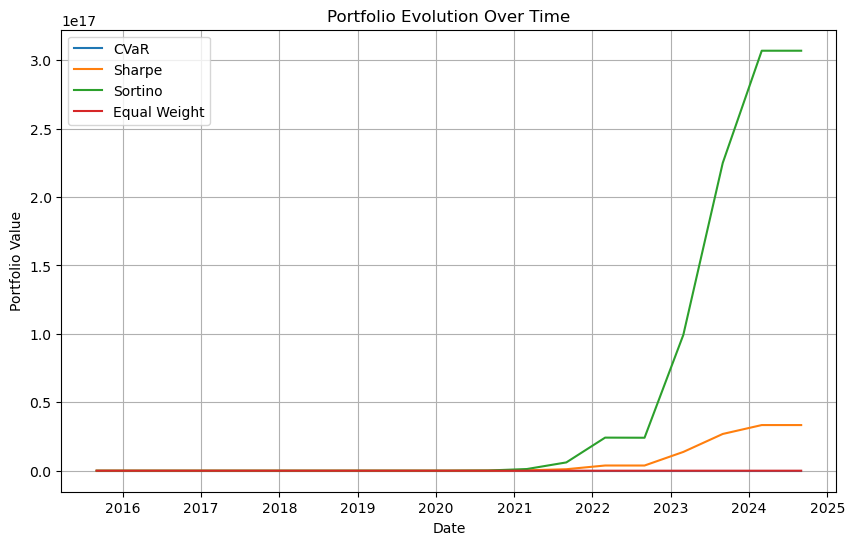

In [19]:
backtest.plot_portfolio_evolution(value)